In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import _pickle as cPickle
import numpy as np

In [2]:
from process_data import load_text_csv, load_ts_csv, transform_text_2_sentences, transform_text_into_vectors, split_into_XY

In [3]:
train, test = load_text_csv(filename='../datasets/stocknews/Combined_News_DJIA.csv')

In [4]:
train.head()

,Label,Combined
0,0,"['b""Georgia \'downs two Russian warplanes\' as..."
1,1,"[""b'Why wont America and Nato help us? If they..."
2,0,"[""b'Remember that adorable 9-year-old who sang..."
3,0,"[""b' U.S. refuses Israel weapons to attack Ira..."
4,1,"[""b'All the experts admit that we should legal..."


In [5]:
data_chng_train, data_chng_test = load_ts_csv(filename='../datasets/stocknews/DJIA_table.csv', date_split=date(2014, 12, 31))

In [6]:
#train_text, test_text = transform_text_2_sentences(train, test)

In [7]:
train_text = cPickle.load(open('../output/train_text.p', 'rb'))[1:]
test_text = cPickle.load(open('../output/test_text.p', 'rb'))[1:]

In [8]:
data_chng_train[:10]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.60302431e-02,  9.11145883e-03,  2.52449265e-02,
         4.09306170e-03, -1.39266081e-01],
       [ 4.43578322e-03, -7.14249219e-03, -6.33896194e-03,
        -1.18719854e-02, -5.24046072e-02],
       [-1.26374481e-02, -1.26094829e-02, -1.27724378e-02,
        -9.40605976e-03,  5.16158765e-02],
       [-8.65992496e-03,  7.26333127e-03, -2.13928516e-04,
         7.19413986e-03, -1.24678170e-01],
       [ 6.86257080e-03, -7.16028701e-04,  1.29981884e-02,
         3.78537958e-03,  3.45766318e-01],
       [ 4.17186755e-03, -1.66183974e-03, -1.42770862e-02,
        -1.54813281e-02, -2.73204985e-01],
       [-1.55716973e-02, -1.81567121e-02, -1.01118508e-02,
        -1.13978048e-02,  9.78309553e-02],
       [-1.15131887e-02, -2.09262724e-03, -2.46675107e-03,
         6.06948766e-03, -1.55612542e-01],
       [ 6.10703356e-03,  1.92590190e-03,  2.21337025e-03,
         1.11936516e-03

In [9]:
train_text_vectors, test_text_vectors, model = transform_text_into_vectors(train_text, test_text, 100)

In [10]:
X_train, X_train_text, Y_train, Y_train2 = split_into_XY(data_chng_train, train_text_vectors, 1, 30, 1)
X_test, X_test_text, Y_test, Y_test2 = split_into_XY(data_chng_test, test_text_vectors, 1, 30, 1)

KEK index 1611 is out of bounds for axis 0 with size 1611
KEK index 378 is out of bounds for axis 0 with size 378


In [11]:
print(X_train.shape)
print(X_test.shape)

(1580, 30, 5)
(347, 30, 5)


In [12]:
print(X_train_text.shape)
print(X_test_text.shape)

(1580, 30, 100)
(347, 30, 100)


In [13]:
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Input, concatenate, LeakyReLU
from keras.layers.recurrent import LSTM

/anaconda3/envs/dlcv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
def build():
    ohlcv_input = Input(shape=(30, 5), name='ts_input')
    lstm_ohlcv = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(ohlcv_input)
    lstm_ohlcv = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(lstm_ohlcv)
    lstm_ohlcv = Flatten()(lstm_ohlcv)
    
    text_input = Input(shape=(30, 100), name='text_input')
    lstm_text = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(text_input)
    lstm_text = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(lstm_text)
    lstm_text = Flatten()(lstm_text)
    
    lstms = concatenate([lstm_ohlcv, lstm_text])
    
    X1 = Dense(64)(lstms)
    X1 = LeakyReLU()(X1)
    X1 = Dense(1, activation='linear', name='regression')(X1)
    
    X2 = Dense(64)(lstms)
    X2 = LeakyReLU()(X2)
    X2 = Dense(1, activation='sigmoid', name='class')(X2)
    
    model = Model(inputs=[ohlcv_input, text_input], outputs=[X1, X2])
    
    return model

model = build()

In [15]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Nadam
opt = Nadam(lr=0.002)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_loss', filepath="../output/multi-modal.hdf5", verbose=1, save_best_only=True)

In [16]:
model.compile(optimizer=opt, loss={'regression': 'mse', 'class': 'binary_crossentropy'}, loss_weights=[1.0, 0.2])

In [17]:
for layer in model.layers:
    print(layer, layer.output_shape)

<keras.engine.topology.InputLayer object at 0x1a291578d0> (None, 30, 5)
<keras.engine.topology.InputLayer object at 0x1a29bd1ef0> (None, 30, 100)
<keras.layers.recurrent.LSTM object at 0x10a9cf6a0> (None, 30, 10)
<keras.layers.recurrent.LSTM object at 0x1a29f34ef0> (None, 30, 10)
<keras.layers.recurrent.LSTM object at 0x1a29157c88> (None, 30, 10)
<keras.layers.recurrent.LSTM object at 0x1a29f50588> (None, 30, 10)
<keras.layers.core.Flatten object at 0x10b5e4048> (None, 300)
<keras.layers.core.Flatten object at 0x1a2a8bc320> (None, 300)
<keras.layers.merge.Concatenate object at 0x1a2a8f3278> (None, 600)
<keras.layers.core.Dense object at 0x1a2a8f3550> (None, 64)
<keras.layers.core.Dense object at 0x1a2ad484a8> (None, 64)
<keras.layers.advanced_activations.LeakyReLU object at 0x1a2ad1f2b0> (None, 64)
<keras.layers.advanced_activations.LeakyReLU object at 0x1a2ad5d240> (None, 64)
<keras.layers.core.Dense object at 0x1a2ad1f5c0> (None, 1)
<keras.layers.core.Dense object at 0x1a2ad5d780> (N

Train on 1580 samples, validate on 347 samples
Epoch 1/100
1580/1580 [==============================] - 2s 1ms/step - loss: 0.1759 - regression_loss: 0.0373 - class_loss: 0.6932 - val_loss: 0.1570 - val_regression_loss: 0.0139 - val_class_loss: 0.7156
Epoch 2/100
1580/1580 [==============================] - 2s 1ms/step - loss: 0.1915 - regression_loss: 0.0531 - class_loss: 0.6919 - val_loss: 0.2150 - val_regression_loss: 0.0764 - val_class_loss: 0.6930
Epoch 3/100
1580/1580 [==============================] - 2s 1ms/step - loss: 0.2586 - regression_loss: 0.1201 - class_loss: 0.6926 - val_loss: 0.1872 - val_regression_loss: 0.0357 - val_class_loss: 0.7578
Epoch 4/100
1580/1580 [==============================] - 2s 1ms/step - loss: 0.1850 - regression_loss: 0.0456 - class_loss: 0.6971 - val_loss: 0.1494 - val_regression_loss: 0.0107 - val_class_loss: 0.6939
Epoch 5/100
1580/1580 [==============================] - 2s 1ms/step - loss: 0.1760 - regression_loss: 0.0373 - class_loss: 0.6935 - 

2018-06-11 23:27:46,945: WARNING: No handles with labels found to put in legend.


NameError: name 'original' is not defined

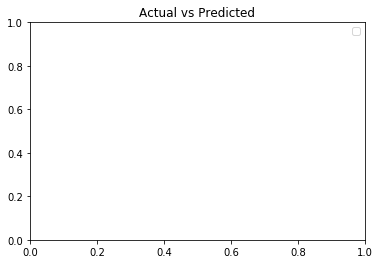

In [19]:
try:
    H = model.fit(
        [X_train, X_train_text], [Y_train, Y_train2],
        epochs=100,
        batch_size=256,
        verbose=1,
        validation_data=([X_test, X_test_text], [Y_test, Y_test2]),
        callbacks=[reduce_lr, checkpointer],
        shuffle=True
    )
    plt.figure()
    plt.plot(H.history['loss'])
    plt.plot(H.history['val_loss'])
    plt.title('Modal Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

except Exception as e:
    print(e)
    


2018-06-11 23:29:15,120: WARNING: No handles with labels found to put in legend.


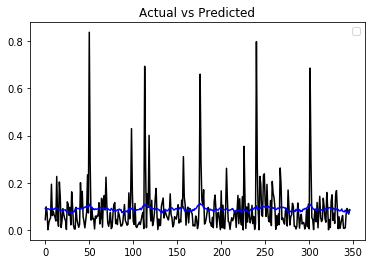

0.010830688230870862
0.062400877833110956
3.1272184914488417


In [24]:

model.load_weights('../output/multi-modal.hdf5')
pred = model.predict([X_test, X_test_text])[0]

plt.title('Actual vs Predicted')
plt.legend(loc='best')
plt.plot(Y_test, color='black', label='Original Data')
plt.plot(pred, color='blue', label='Predicted Data')
plt.show()

print(np.mean(np.square(pred - Y_test)))
print(np.mean(np.abs(pred - Y_test)))
print(np.mean(np.abs((Y_test - pred)/Y_test)))

2018-06-11 23:32:58,035: WARNING: No handles with labels found to put in legend.


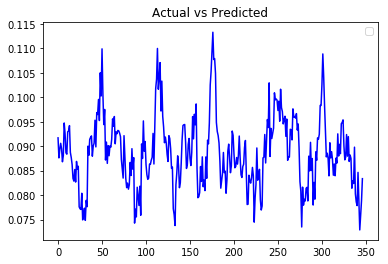

In [25]:
plt.title('Actual vs Predicted')
plt.legend(loc='best')
#plt.plot(Y_test, color='black', label='Original Data')
plt.plot(pred, color='blue', label='Predicted Data')
plt.show()